## This notebook implements source estimation for emission equation by minimizing relative entropy and L1 norm by means of conic programming 

The detailed deriviations can be found here: ???

The notebook has 3 main parts:
1. Problem definition (functions, forms, geometry etc.)
2. Solving forward emission equation for generating pseudo observations.
3. Solving source estimation problem

In [1]:
import fenics as fem

import mshr
import numpy as np
import math 

import scipy
import scipy.sparse as sp
import scipy.optimize as spo
from scipy.interpolate import RectBivariateSpline

import cvxpy as cp 

import matplotlib.pyplot as plt
import sklearn 
from sklearn.utils import extmath 

from IPython import display
import time
from tqdm import trange, tqdm
import mosek 


(CVXPY) Jul 03 05:06:54 PM: Encountered unexpected exception importing solver SCIP:
NotImplementedError("PySCIPOpt (SCIP's Python wrapper) is installed and itsversion is 4.2.0. CVXPY only supports PySCIPOpt < 4.0.0.")


#### DOMAIN / FEM setup 

In [2]:
#paralelepiped enclosing the cylinder 
lb_x = 0.0
lb_y = 0.0
lb_z = 0.0
rb_x = 3.6/10*4
rb_y = 3.6/10*4
rb_z = 4.5/10*4#0.45 


degree = 1    # polynomial degree

In [3]:
PROBLEM = '3D'
# Create mesh
# 2D mesh
if PROBLEM == '2D':
    nsteps = 3
    coordinate_degree = 1
    gdim = 2
    mesh = fem.UnitDiscMesh.create(fem.MPI.comm_world, nsteps, coordinate_degree, gdim)
    fem.plot(mesh)
    #mesh = fem.RectangleMesh(fem.Point(lb_x, lb_y), fem.Point(rb_x, rb_y), Nel_x, Nel_y)
    #elements = 'triangle'

# 3D mesh
if PROBLEM == '3D':
#     geometry = mshr.Cylinder(fem.Point((lb_x+rb_x)/2,(lb_y+rb_y)/2,lb_z), fem.Point((lb_x+rb_x)/2,(lb_y+rb_y)/2,rb_z), radius, radius)
#     mesh = mshr.generate_mesh(geometry, 15)
    Nel_x = 18#16#14
    Nel_y = 18#16#14
    Nel_z = 22#20#16
    
mesh = fem.BoxMesh(fem.Point(lb_x, lb_y, lb_z), fem.Point(rb_x, rb_y, rb_z), Nel_x, Nel_y, Nel_z)
elements = 'tetrahedron'

#### Generating synthetic observations

In [4]:
# define Sigma to be an integration area where observations are present.
# This is done by defining marker function, i.e., binary labels for grid nodes where observations are given. 
# Note: In a case considered here this is a boundary of a 2D or 3D domain 

# marker function for observed nodes. Defines logical expression for labeling such nodes.
# Note: use <near> instead of == (equality sign) to avoid problem with numerical rounding.
# Note: use on_boundary marker to be sure only boundary nodes would be considered.
# Note: x[0] defines first coordinate of node x, x[1] - the second, x[2] - the third and so on, i.e., (x,y)=(x[0],x[1])
# Note: to define marker you can use logical operations (e.g., &&, ||) and binary operations (>, <, sqrt, near, etc.)
# Note: the present approach will compile marker function string into efficient C++ code, 
# however it is also possible to write Python class to be a marker function (it will be slower but more epressive). 
# More details with examples can be found here: https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html

top_boundary_marker = fem.CompiledSubDomain(f'(near(x[2], {lb_z}) || near(x[2], {rb_z}) || near(x[1], {rb_y}) || near(x[1], {lb_y}) || near(x[0], {rb_x}) || near(x[0], {lb_x}))  && on_boundary')

eps = 1e-10 
num_el = 3
lbx_marker = lb_x + num_el*(rb_x-lb_x)/Nel_x + eps
rbx_marker = rb_x - num_el*(rb_x-lb_x)/Nel_x - eps

lby_marker = lb_y + num_el*(rb_y-lb_y)/Nel_y + eps
rby_marker = rb_y - num_el*(rb_y-lb_y)/Nel_y - eps

lbz_marker = lb_z + num_el*(rb_z-lb_z)/Nel_z + eps
rbz_marker = rb_z - num_el*(rb_z-lb_z)/Nel_z - eps

near_boundary_marker = fem.CompiledSubDomain(f'(x[0]<{lbx_marker} || x[0]> {rbx_marker}) &&'+
                                             f'(x[1]<{lby_marker} || x[1]> {rby_marker}) &&'+
                                             f'(x[2]<{lbz_marker} || x[2]> {rbz_marker})')
print('WARNING: SUPPORT OF mu_axf must be in ', '[', lbx_marker, ',', rbx_marker, ']', lby_marker, rby_marker, lbz_marker, rbz_marker)
sub_domains = fem.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
sub_domains.set_all(0)
top_boundary_marker.mark(sub_domains, 1)
dSigma = fem.ds(subdomain_id=1, subdomain_data=sub_domains, domain=mesh)


In [5]:
# Define function spaces
P1 = fem.FiniteElement('P', elements, degree)
Q  = fem.FunctionSpace(mesh, P1) 

# mixed_el4 = fem.MixedElement([P1, P1, P1, P1])
# mixed_el5 = fem.MixedElement([P1, P1, P1, P1, P1])

# mixed_el2 = fem.MixedElement([P1, P1])

# V = fem.FunctionSpace(mesh, mixed_el4)
# V5 = fem.FunctionSpace(mesh, mixed_el5)x

# W = fem.FunctionSpace(mesh, mixed_el2)


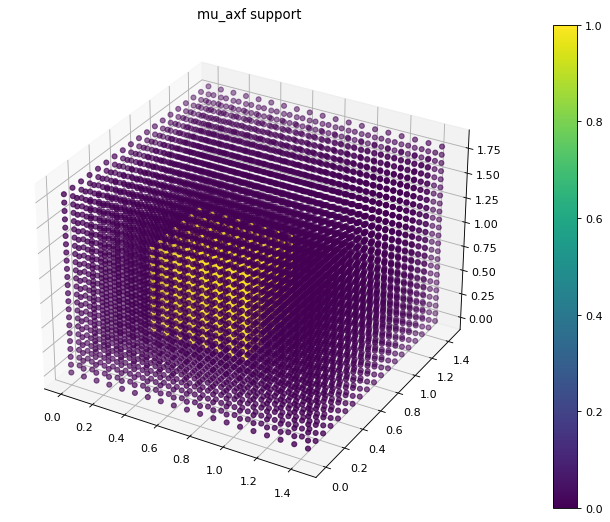

In [12]:
#DEFINE SUPPORT OF mu_axf - a polytope in the form [x_l,x_r] x [y_l,y_r] x [z_l, z_r]
y_r = 0.2*4
y_l = 0.25

x_r = 0.9
x_l = 0.25

z_l = 0.25
z_r = (0.3+0.1)*3

if (x_l < lbx_marker or x_r > rbx_marker or y_l < lby_marker or y_r > rby_marker or z_l < lbz_marker or z_r > rbz_marker): 
    print('WARNING: SUPPORT OF mu_axf - [x_l,x_r] x [y_l,y_r] x [z_l, z_r] should be in the complement of near_boundary_marker!')

XiPhantom = fem.Function(Q)

def InsideCube(x,y,z,lb,rb):
    if rb[0]==rb_x:
        cond_x = (x <= rb[0] and x >= lb[0])
    else:
        cond_x = (x < rb[0] and x >= lb[0])
    
    if rb[1]==rb_y:    
        cond_y = (y <= rb[1] and y >= lb[1])
    else:
        cond_y = (y < rb[1] and y >= lb[1])
    
    if rb[2] == rb_z: 
        cond_z = (z <= rb[2] and z >= lb[2])
    else: 
        cond_z = (z < rb[2] and z >= lb[2])
        
    if cond_x and cond_y and cond_z:
        return 1
    return 0

dofs = Q.tabulate_dof_coordinates()

for i in range(dofs.shape[0]): 
    if InsideCube(dofs[i,0],dofs[i,1],dofs[i,2],[x_l,y_l,z_l],[x_r,y_r,z_r]): 
        XiPhantom.vector()[i] = 1
    else:
        XiPhantom.vector()[i] = 0
        
# for i in range(dofs.shape[0]):
#     if dofs[i,2]<=0.3 and dofs[i,2]> 0.0005 and InsideSquare1(dofs[i,0],dofs[i,1]):
#         XiPhantom.vector()[i] = 1
#     else:
#         XiPhantom.vector()[i] = 0
        
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
img = fem.plot(XiPhantom)
plt.colorbar(img)
tmp = plt.title('mu_axf support')

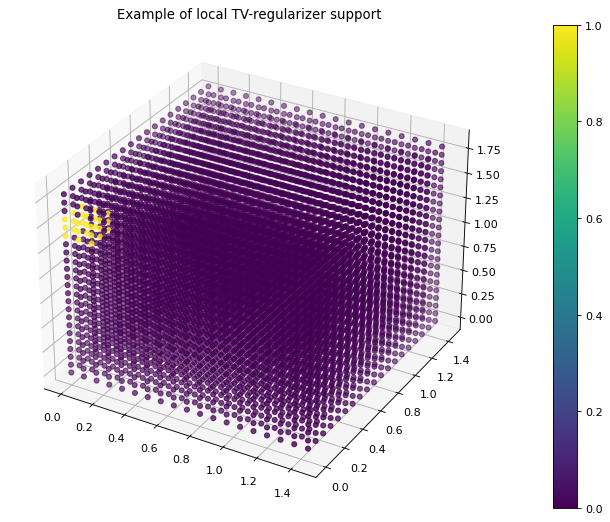

In [82]:
# DEFINE supports for local Total Variation regularization 
Nc_x = 8
Nc_y = 8 
Nc_z = 8 

Cubes_xcoord = np.linspace(lb_x, rb_x, Nc_x+1, endpoint=True) 
Cubes_ycoord = np.linspace(lb_y, rb_y, Nc_y+1, endpoint=True) 
Cubes_zcoord = np.linspace(lb_z, rb_z, Nc_z+1, endpoint=True) 
TV_cubes_index = np.zeros(shape=[1, dofs.shape[0]],dtype=int)#Nc_x*Nc_y*Nc_z])

for jx in range(1,len(Cubes_xcoord)):
    for jy in range(1,len(Cubes_ycoord)):
        for jz in range(1,len(Cubes_zcoord)):
            lb_tmp = np.array([Cubes_xcoord[jx-1],Cubes_ycoord[jy-1],Cubes_zcoord[jz-1]])
            rb_tmp = np.array([Cubes_xcoord[jx],Cubes_ycoord[jy],Cubes_zcoord[jz]])
            tmp = np.zeros(dofs.shape[0],dtype=int)
            for ii in range(dofs.shape[0]):
                tmp[ii] = InsideCube(dofs[ii,0],dofs[ii,1],dofs[ii,2],lb_tmp,rb_tmp)
                
            TV_cubes_index = np.append(TV_cubes_index,[tmp],axis=0)


plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
tmp = fem.Function(Q)
tmp.vector()[:] = TV_cubes_index[7,:]
img = fem.plot(tmp)
plt.colorbar(img)
tmp = plt.title('Example of local TV-regularizer support')

#### COEFFICIENTS & Bilinear FORMS (weak form) 

In [83]:
# DEFINE coefficents for EXCITATION EQ
# absorption coefficent of the medium at fluorophore excitation wl
mu_axi = fem.Function(Q)
# absoption of Liposyne at 785nm (ICG excitation)
mu_axi.vector()[:] = 0.023 * np.ones(mu_axi.vector()[:].shape)

# absorption coefficent due to fluorophore at fluorophore excitation wl
mu_axf = fem.Function(Q)
#absoption of ICG at 785nm: depends on concetration, approx. 0.5 per 1 micromolar 
ICG_absoption_coeff = fem.Constant(0.5)
# print('TODO: drop ICG_absorption to 0.2')
# support of ICG concentration in the domain 
mu_axf.vector()[:] = ICG_absoption_coeff*XiPhantom.vector()[:]

# scattering coefficent of the medium at fluorophore excitation wl
mu_sxp = fem.Function(Q)
# scattering of Liposyne at 785nm 
mu_sxp.vector()[:] = 9.84 * np.ones(mu_sxp.vector()[:].shape)

# diffusion coefficient 
# dx = 1/(3*(mu_axi + mu_axf + mu_sxp))
print('NOTE: dropped mu_axf from Dx')

dx = 1/(3*(mu_axi + mu_sxp))
#absoption coefficient 
kx = mu_axi + mu_axf

#Bilinear form for the weak formulation of the EXCITATION EQ 
def ax_form(u,v):
    return dx*fem.dot(fem.grad(u), fem.grad(v))*fem.dx + kx*u*v*fem.dx     + 0.5*g*u*v*fem.ds

#EXCITATION EQ without mu_axf (e.g. no fluorophore ) 
def ax_nomuaxf_form(u,v):
    return dx*fem.dot(fem.grad(u), fem.grad(v))*fem.dx + mu_axi*u*v*fem.dx + 0.5*g*u*v*fem.ds

NOTE: dropped mu_axf from Dx


In [84]:
#EMISSION EQ
# absorption coefficent of the medium at fluorophore emission wl
mu_ami = fem.Function(Q)
# absoption of Liposyne at 830nm (ICG emission) 
mu_ami.vector()[:] = 0.0289 * np.ones(mu_ami.vector()[:].shape)

# absorption coefficent due to fluorophore at fluorophore emission wl 
mu_amf = fem.Function(Q)
# we assume that there is no quenching (Donal:ICG concentration must be below 10-15 micromolar depending on the medium ICG is enclosed in)
mu_amf.vector()[:] = np.zeros(mu_amf.vector()[:].shape)

# scattering coefficent of the medium at fluorophore emission wl 
mu_smp = fem.Function(Q)
# scattering of Liposyne at 830nm 
mu_smp.vector()[:] = 9.84 * np.ones(mu_smp.vector()[:].shape)

# diffusion coefficient 
dm = 1/(3*(mu_ami + mu_amf + mu_smp))
#absoption coefficient 
km = mu_ami + mu_amf

#gamma for the Robin boundary condition comes from Table 1 of this paper for air / Liposyne interface: 
#https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-10-15-653&id=69564 
g = fem.Constant(2.5156)
#ICG quantum efficiency 
Gm = fem.Constant(0.016)

#Bilinear form for the weak formulation of the EMISSION EQ
def am_form(u,v):
    return dm*fem.dot(fem.grad(u), fem.grad(v))*fem.dx + km*u*v*fem.dx + 0.5*g*u*v*fem.ds

### SOURCE term

In [15]:
class SourceExpression(fem.UserExpression):
    def eval(self, value, x):
        value[0] = 0
#         value[1] = 0
        if PROBLEM == '2D':
            if (abs((lb_x+rb_x)/2.0 - x[0]) < 0.5) & fem.near(x[1], lb_y):
                value[0] = np.sin(np.pi*x[0])

        if PROBLEM == '3D':
            if fem.near(x[2], rb_z):
                value[0] = 1e3*(20+10*np.sin(np.pi*x[0]))
                # value[0] = (20+10*np.sin(np.pi*x[0]))

    def value_shape(self):
        return ()

trueSource = fem.interpolate(SourceExpression(), Q)   # source

#### UNIT tests

In [17]:
#UNIT test 1: is the "fake source" Sf = mu_axf*phi_x reconstructing the solution phi_x well? 

ux = fem.TrialFunction(Q)
vx = fem.TestFunction(Q)

ax_muax  = ax_form(ux, vx) 
rhs = trueSource/2*vx*fem.ds 

hatphi = fem.Function(Q)
phibar = fem.Function(Q)
Sf     = fem.Function(Q)
phiSf = fem.Function(Q)

print('State space dimension = ', phiSf.vector()[:].size)

fem.solve(ax_muax==rhs, hatphi, solver_parameters={'linear_solver':'mumps'})
print('Phi_x >= 0:  ', np.all(hatphi.vector()[:]>=0), '\n#(<0) = ', np.sum(hatphi.vector()[:]<0), '2norm % of (<0)', np.linalg.norm(hatphi.vector()[hatphi.vector()[:]<0])/np.linalg.norm(hatphi.vector()[:]), 'Min Phi_x = ', np.min(hatphi.vector()[:]))

fem.solve(ax_nomuaxf_form(ux, vx) == trueSource/2*vx*fem.ds, phibar, solver_parameters={'linear_solver':'mumps'})
print('Phi_bar >= 0: ', np.all(phibar.vector()[:]>=0), '\n#(<0) = ', np.sum(phibar.vector()[:]<0), '2norm % of (<0)', np.linalg.norm(phibar.vector()[phibar.vector()[:]<0])/np.linalg.norm(phibar.vector()[:]),'Min Phi_bar = ', np.min(phibar.vector()[:]))

diff_phibar_x = phibar.vector()[:] - hatphi.vector()[:]
print('Phi_bar >= Phi_x', np.all(diff_phibar_x>=0))#, phibar.vector()[diff_phibar_x<0],hatphi.vector()[diff_phibar_x<0])
    
if np.min(phibar.vector()[:])<0:
    print('WARNING: FEM solution Phi_bar has', np.sum(phibar.vector()[:]<0), 'negative components! Setting negatives to 0!')
    tmp_ind = phibar.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    phibar.vector()[:] = tmp_ind 

if np.min(hatphi.vector()[:])<0:
    print('WARNING: FEM solution Phi_x has', np.sum(hatphi.vector()[:]<0), ' negative components! Setting negatives to 0!')
    tmp_ind = hatphi.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    hatphi.vector()[:] = tmp_ind 
    
diff_phibar_x = phibar.vector()[:] - hatphi.vector()[:]
print('Phi_bar >= Phi_x', np.all(diff_phibar_x>=0), '\n Diff: ',[phibar.vector()[diff_phibar_x<0],hatphi.vector()[diff_phibar_x<0]], '\n', np.linalg.norm(diff_phibar_x)/np.linalg.norm(hatphi.vector()[:]))


# fake source Sf = mu_axf*hatphi
Sf.vector()[:] = np.multiply(mu_axf.vector()[:], hatphi.vector()[:])

ax0  = ax_nomuaxf_form(ux, vx) 
rhsSf = trueSource/2*vx*fem.ds - Sf*vx*fem.dx
print('WARNING: FEM interpolation error - if Sf in rhsSf is substituted by mu_axf*hatphi then Phi_Sf = Phi_x!')

fem.solve(ax0 ==rhsSf, phiSf, solver_parameters={'linear_solver':'mumps'})
print('Phi_Sf >= 0:  ', np.all(phiSf.vector()[:]>=0), '\n#(<0) = ', np.sum(phiSf.vector()[:]<0), 'Min Phi_Sf = ', np.min(phiSf.vector()[:]))

if np.min(phiSf.vector()[:])<0:
    print('WARNING: FEM solution Phi_Sf has ', np.sum(phiSf.vector()[:]<0), 'negative components', 'out of', phiSf.vector()[:].size,'Setting negatives to 0!')
    tmp_ind = phiSf.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    phiSf.vector()[:] = tmp_ind 


print('FEM INterpolation error: \nRel. Rn-err: |Phi_x - Phi_Sf|  = ', np.linalg.norm(phiSf.vector()[:] - hatphi.vector()[:])/np.linalg.norm(hatphi.vector()[:]))
print('Rel. L2-err: |Phi_ex - Phi_Sf|  = ', np.sqrt(fem.assemble((hatphi-phiSf)**2*fem.dx))/np.sqrt(fem.assemble(hatphi**2*fem.dx)))





Solving linear variational problem.
Phi_x >= 0:   False 
#(<0) =  88 2norm % of (<0) 0.0012089793495925333 Min Phi_x =  -223.48100190438024
Solving linear variational problem.
Phi_bar >= 0:  False 
#(<0) =  83 2norm % of (<0) 0.0011989790928799364 Min Phi_bar =  -223.42616758368348
Phi_bar >= Phi_x False
Phi_bar >= Phi_x False 
 Diff:  [array([0.00000000e+00, 0.00000000e+00, 1.11347250e-03, 9.56348424e-04,
       1.14331716e-03, 1.15178605e-03, 7.71496324e-01, 1.03464238e+00,
       3.02055819e-08, 1.41988922e+00, 2.01630550e+00, 3.01293579e+00,
       4.85594108e+00, 8.88654798e+00, 2.87038549e+01, 5.14041302e+02,
       3.39489742e+03, 3.64136138e+03, 3.41302581e+03, 4.08912551e+03,
       3.42202028e+03, 4.69239493e+03, 3.42573425e+03, 5.41599823e+03,
       3.42747134e+03, 6.21559409e+03, 3.42838784e+03, 7.04137570e+03,
       3.42892806e+03, 7.84164729e+03, 3.42928560e+03, 8.56622372e+03,
       3.42955730e+03, 9.16964195e+03, 3.42980177e+03, 6.87273789e+03,
       6.81199206e+03,

#### RESCALING 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.WARNING: FEM solution Phi_Sf has negative components! Setting negatives to 0!

10305209.931563996 0.0004370857795698835 0.9999712223841455 6.038449345526987e-06 0.023063521805832307 1.0008391300136286
Rel. Rn-err: |Phi_ex - Phi_Sf|  =  0.0008205514986119658
Rel. L2-err: |Phi_ex - Phi_Sf|  =  0.0009450367916701003
Solving linear variational problem.
Phi_bar >= 0:  True 
Min Phi_bar =  0.0 Min Phi_ex =  0.0


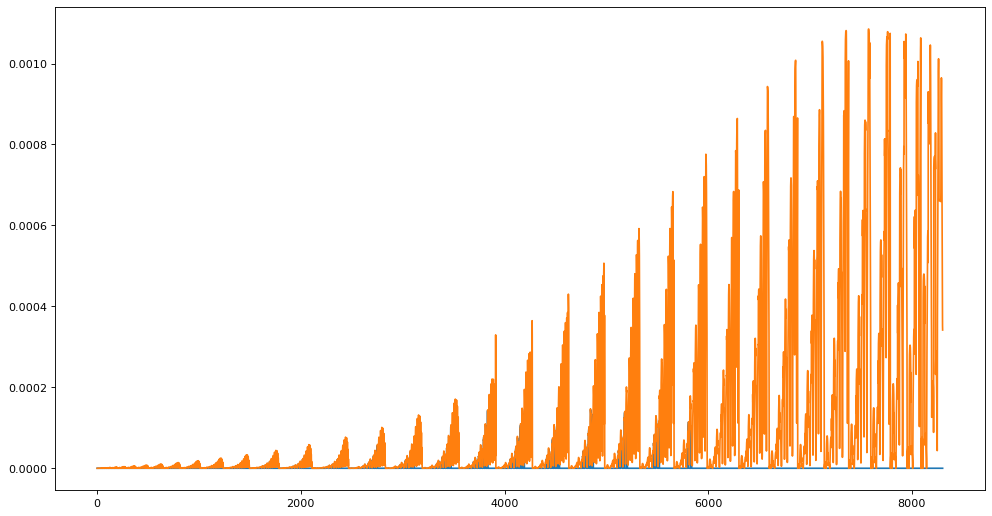

In [18]:
scale             = hatphi.vector()[:].sum() #fem.assemble(hatphi*fem.dx) 
SrcBndr_scaled    = trueSource/2/scale*vx*fem.ds 
hatphi_scaled     = fem.Function(Q)
fenics_solver = 'bicgstab'

fem.solve(ax_muax == SrcBndr_scaled, hatphi_scaled, solver_parameters={'linear_solver':fenics_solver,'preconditioner': 'ilu'})
if np.min(hatphi_scaled.vector()[:])<0:
    print('WARNING: FEM solution Phi_x has negative components! Setting negatives to 0!')
    tmp_ind = hatphi_scaled.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    hatphi_scaled.vector()[:] = tmp_ind 
    
Sf_scaled     = fem.Function(Q)
Sf_scaled.vector()[:] = np.multiply(mu_axf.vector()[:], hatphi_scaled.vector()[:])

phiSf_scaled = fem.Function(Q)
fem.solve(ax0 ==SrcBndr_scaled - Sf_scaled*vx*fem.dx, phiSf_scaled, solver_parameters={'linear_solver':fenics_solver,'preconditioner': 'ilu'})

if np.min(phiSf_scaled.vector()[:])<0:
    print('WARNING: FEM solution Phi_Sf has negative components! Setting negatives to 0!')
    tmp_ind = phiSf_scaled.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    phiSf_scaled.vector()[:] = tmp_ind 



print(scale, fem.assemble(hatphi_scaled*fem.dx), (hatphi_scaled.vector()[:]).sum(), fem.assemble(Sf_scaled*fem.dx), (Sf_scaled.vector()[:]).sum()/float(ICG_absoption_coeff), phiSf_scaled.vector()[:].sum()) 

print('Rel. Rn-err: |Phi_ex - Phi_Sf|  = ', np.linalg.norm(phiSf_scaled.vector()[:] - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:]))
print('Rel. L2-err: |Phi_ex - Phi_Sf|  = ', np.sqrt(fem.assemble((hatphi_scaled-phiSf_scaled)**2*fem.dx))/np.sqrt(fem.assemble(hatphi_scaled**2*fem.dx)))

phibar_scaled = fem.Function(Q)
fem.solve(ax_nomuaxf_form(ux, vx) == SrcBndr_scaled, phibar_scaled, solver_parameters={'linear_solver':'mumps'})
if np.min(phibar_scaled.vector()[:])<0:
    print('WARNING: FEM solution Phi_bar has negative components! Setting negatives to 0!')
    tmp_ind = phibar_scaled.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    phibar_scaled.vector()[:] = tmp_ind 



print('Phi_bar >= 0: ', np.all(phibar_scaled.vector()[:]>=0), '\nMin Phi_bar = ', np.min(phibar_scaled.vector()[:]), 'Min Phi_ex = ', np.min(hatphi_scaled.vector()[:]))

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Sf_scaled.vector()[:]/float(ICG_absoption_coeff))
plt.plot(hatphi_scaled.vector()[:])

# plt.plot(mu_axf.vector()[:]/float(ICG_absoption_coeff))

In [19]:
#Relative ENTROPY tests 
tmp_denom = phiSf_scaled.vector()[:]*mu_axf.vector()[:]/float(ICG_absoption_coeff)
tmp_nom = Sf_scaled.vector()[:]
print('Sum (Sf Log ( Sf / Phi_Sf)) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff), phiSf_scaled.vector()[:]).sum(), '\nSum Sf Log (Sum Sf / Sum_{Sf>0} Phi_Sf) = ', scipy.special.rel_entr(tmp_nom.sum()/float(ICG_absoption_coeff),tmp_denom.sum()), '\nSum Sf Log (Sum Sf) = ',Sf_scaled.vector()[:].sum()/float(ICG_absoption_coeff)*np.log(Sf_scaled.vector()[:].sum()/float(ICG_absoption_coeff)))
#check ratio sf / sol
tmp = Sf_scaled.vector()[:]/float(ICG_absoption_coeff)/phiSf_scaled.vector()[:]
print('max (Sf / Phi_Sf) =', np.max(tmp[tmp>0]), 'min (Sf_nnz / phiSf) = ', np.min(tmp[tmp>0]))#,tmp_nom.sum()+0.1,tmp_denom.sum(), scipy.special.rel_entr(tmp_nom.sum()+0.0004,tmp_denom.sum()),tmp_nom.sum()*np.log(tmp_nom.sum()/tmp_denom.sum()))

Sum (Sf Log ( Sf / Phi_Sf)) =  -0.00019510782188869108 
Sum Sf Log (Sum Sf / Sum_{Sf>0} Phi_Sf) =  -0.00019521508926259172 
Sum Sf Log (Sum Sf) =  -0.08693801584200256
max (Sf / Phi_Sf) = 1.005035473433028 min (Sf_nnz / phiSf) =  0.9828882310736421


/var/folders/2p/gfsz2k6j1j76ndl25fq252sr0000gn/T/ipykernel_56420/3140621345.py:6: RuntimeWarning: invalid value encountered in divide
  tmp = Sf_scaled.vector()[:]/float(ICG_absoption_coeff)/phiSf_scaled.vector()[:]


In [20]:
#GENERATE SYNTHETIC OBSERVATIONS
M = fem.assemble(ux*vx*fem.dx).array()
print(' Mass matrix >= 0 ', np.all(M>=0)) 

S_excite = fem.assemble(ax_nomuaxf_form(ux, vx)).array()
# A_excite = np.linalg.solve(S_excite,M)

S_emit = fem.assemble(am_form(ux, vx)).array()
dofs = Q.tabulate_dof_coordinates()
is_dof_on_boundary = np.array([top_boundary_marker.inside(point, True) for point in dofs])

is_dof_near_boundary = np.array([near_boundary_marker.inside(point, True) for point in dofs])
is_dof_inner = np.array([not near_boundary_marker.inside(point, True) for point in dofs])

# is_TV_bdr_layer = np.array([TV_bdr_layer_marker.inside(point, True) for point in dofs])
# not_TV_bdr_layer = np.array([not TV_bdr_layer_marker.inside(point, True) for point in dofs])

# is_dof_on_boundary = np.array([top_boundary_marker.inside(point, True) for point in dofs])

Tr       = np.eye(dofs.shape[0])[is_dof_on_boundary, :]
Tr_near  = np.eye(dofs.shape[0])[is_dof_near_boundary, :]
Tr_inner = np.eye(dofs.shape[0])[:,is_dof_inner]

print('Inner cube points = ', Tr_inner.shape)
if np.abs(Tr_near@Sf_scaled.vector()[:]).sum()==0 and np.abs(Sf_scaled.vector()[:] - Tr_inner@Sf_scaled.vector()[is_dof_inner]).sum()==0: 
    print('True Sf is in the inner cube.')
else:
    print(np.abs(Tr_near@Sf_scaled.vector()[:]).sum(), np.abs(Sf_scaled.vector()[:] - Tr_inner@Sf_scaled.vector()[is_dof_inner]).sum())
        

A_bdr = Tr@np.linalg.solve(S_emit,float(Gm)*M)

y_tr_scaled = A_bdr@Sf_scaled.vector()[:]

tmp = Sf_scaled.vector()[is_dof_inner]
print(np.linalg.norm(y_tr_scaled - A_bdr@Tr_inner@tmp)/np.linalg.norm(y_tr_scaled), np.linalg.norm(y_tr_scaled - A_bdr@Sf_scaled.vector()[:]))

 Mass matrix >= 0  True
Inner cube points =  (8303, 7791)
True Sf is in the inner cube.
9.782869164419272e-17 0.0


In [21]:
#UNIT TEST2 find phi_x corresponding to the source term of the form Sf = mu_axf phi_x: phi_x = Sˆ-1 M Sf, (note that Sf as defined above cannot be used as it is missing Mass matrix M in its definition)

src_bndr_scaled = fem.assemble(SrcBndr_scaled)
print('Src boundary >= 0', np.all(src_bndr_scaled>=0))
# Tr = np.eye(S.shape[0])
print('Rel. Rn-err |S_ex phibar        - S_bndr| = ', np.linalg.norm(S_excite@phibar_scaled.vector()[:]- src_bndr_scaled)/np.linalg.norm(src_bndr_scaled))
print('Rel. Rn-err |S_ex hatphi + M Sf - S_bndr| = ', np.linalg.norm(S_excite@hatphi_scaled.vector()[:] + M@Sf_scaled.vector()[:] - src_bndr_scaled)/np.linalg.norm(src_bndr_scaled))
print('Rel. Rn-err |S_ex Phi_sf + M Sf - S_bndr| = ', np.linalg.norm(S_excite@phiSf_scaled.vector()[:] + M@Sf_scaled.vector()[:] - src_bndr_scaled)/np.linalg.norm(src_bndr_scaled))

hatphi_Sf = np.linalg.solve(S_excite, src_bndr_scaled-M@Sf_scaled.vector()[:])
print('NP solver error = ', np.linalg.norm(S_excite@hatphi_Sf + M@Sf_scaled.vector()[:] - src_bndr_scaled)/np.linalg.norm(src_bndr_scaled))
print('hatphi_Sf >= 0', np.all(hatphi_Sf>=0), '\nFEM INterpolation error: \nRel. Rn-err |hatphi_Sf - hatphi| = ', np.linalg.norm(hatphi_Sf - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:]))
print('Rel. Rn-err |hatphi_Sf - Phi_Sf| = ', np.linalg.norm(hatphi_Sf - phiSf_scaled.vector()[:])/np.linalg.norm(phiSf_scaled.vector()[:]))

np.linalg.norm(M@np.diag(hatphi_scaled.vector()[:])@mu_axf.vector()[:]/float(ICG_absoption_coeff) - M@Sf_scaled.vector()[:]/float(ICG_absoption_coeff) )

Calling FFC just-in-time (JIT) compiler, this may take some time.
Src boundary >= 0 True
Rel. Rn-err |S_ex phibar        - S_bndr| =  0.001731476743489135
Rel. Rn-err |S_ex hatphi + M Sf - S_bndr| =  0.0017344962628294686
Rel. Rn-err |S_ex Phi_sf + M Sf - S_bndr| =  0.0017318253663998228
NP solver error =  1.00170514488345e-15
hatphi_Sf >= 0 False 
FEM INterpolation error: 
Rel. Rn-err |hatphi_Sf - hatphi| =  0.0014644723256610945
Rel. Rn-err |hatphi_Sf - Phi_Sf| =  0.0012087158730778235


0.0

#### mu_axf estimation

0.03283591290358047 -4.993157513431996e-09


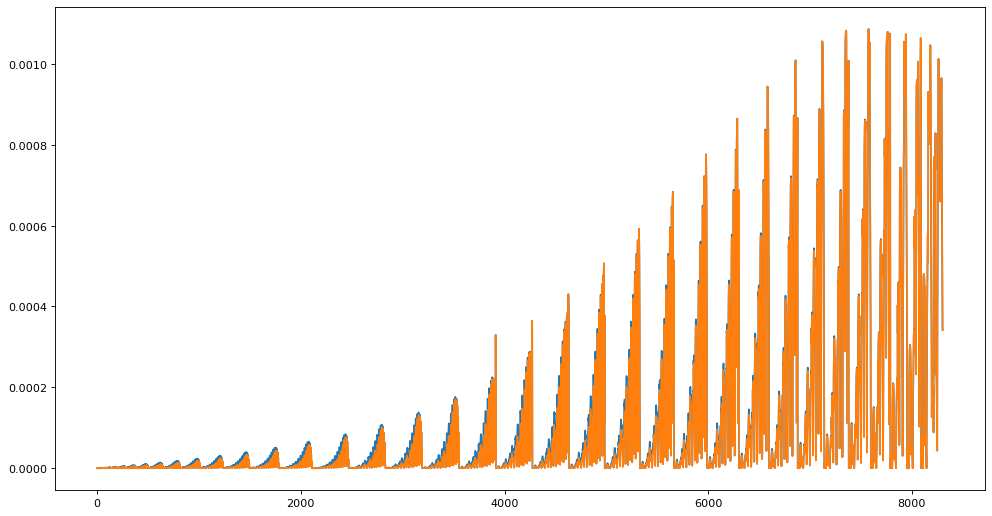

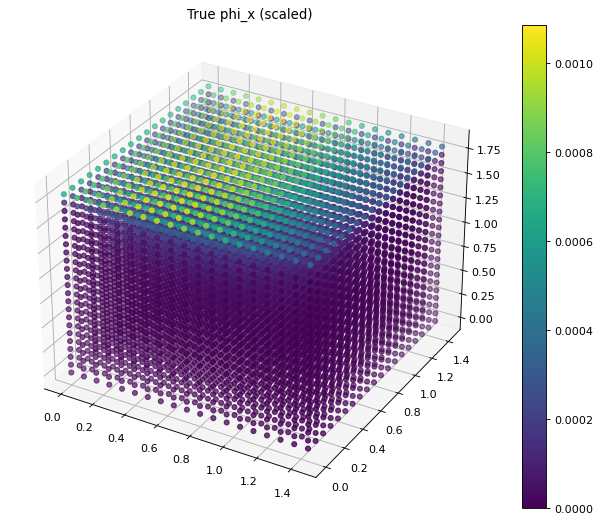

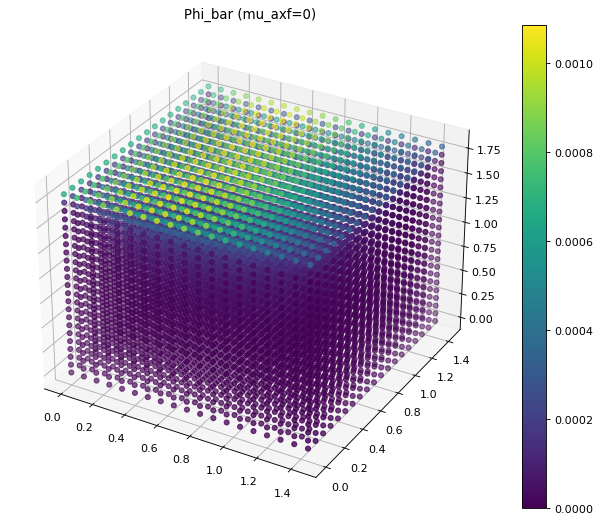

In [22]:
plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(phibar_scaled.vector()[:])
plt.plot(hatphi_scaled.vector()[:])

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,2)
img = fem.plot(hatphi_scaled)
plt.colorbar(img)
plt.title('True phi_x (scaled)')

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
img1 = fem.plot(phibar_scaled)
plt.colorbar(img1)
plt.title('Phi_bar (mu_axf=0)')

print(np.linalg.norm(phibar_scaled.vector()[:]-hatphi_scaled.vector()[:])/np.linalg.norm(phibar_scaled.vector()), np.min(phibar_scaled.vector()[:]-hatphi_scaled.vector()[:]))

In [46]:
# Phi_ex, true light distribution in the cube due to the normalised source
# The source is normalized so that Phi_ex is a probability distribution: sum Phi_ex = 1, Phi_ex >= 0 
# phibar_scaled - light distribution in the domain with no absoption due to the same normalized source



A_bdr_scaled = A_bdr#/np.transpose(np.matlib.repmat(y_tr_scaled,A_bdr.shape[1],1))
# y_tr_sign = y_tr_scaled#np.sign(y_tr_scaled)

nS = Tr_inner.shape[1]

nD = len(phibar.vector()[:])
# nS = nD 

# EmissionEq_tol                = cp.Parameter(1)
# ExcitationEq_tol              = cp.Parameter(1)
# min_portion_of_Phiex_in_muaxf = cp.Parameter(shape=1) 
# rel_absoption_strength        = cp.Parameter(shape=1) 

Svar = cp.Variable(shape=nS, nonneg=True)
Dvar = cp.Variable(shape=nD, nonneg=True)

ExcitationEq_tol = 2e-3
EmissionEq_tol   = 1e-9

min_portion_of_Phiex_in_muaxf  =  0.001 # lower bound on how much of distribution's mass is contained in the support of mu_axf
rel_absoption_strength         = 0.5 # maximal number c>0 such that Phi_ex >= c Phi_bar 

constraints = [Dvar>=phibar_scaled.vector()[:]*rel_absoption_strength, Svar<=Dvar[is_dof_inner], 
               Dvar<= phibar_scaled.vector()[:], 
               cp.norm(S_excite@Dvar + M@Tr_inner@Svar - src_bndr_scaled,2) <= ExcitationEq_tol*np.linalg.norm(src_bndr_scaled), 
#                S_excite@Dvar + M@Tr_inner@Svar >= 0.9*src_bndr_scaled,
               # cp.norm(A_bdr_scaled@Tr_inner@Svar - y_tr_scaled,2)<=EmissionEq_tol*np.linalg.norm(y_tr_scaled,2), 
               A_bdr_scaled@Tr_inner@Svar == y_tr_scaled, 
               cp.sum(Dvar)==1, cp.sum(Svar)>=min_portion_of_Phiex_in_muaxf*float(ICG_absoption_coeff)] 
#                cp.sum(Svar) <= float(ICG_absoption_coeff)*1.5*min_portion_of_Phiex_in_muaxf]
cost = cp.sum(cp.rel_entr(Svar/float(ICG_absoption_coeff), Dvar[is_dof_inner])) +  cp.sum(Svar)#np.abs(np.log(min_portion_of_Phiex_in_muaxf))/float(ICG_absoption_coeff)*cp.sum(Svar)
prob = cp.Problem(cp.Minimize(cost), constraints)

solver = cp.SCS
solver = cp.ECOS
solver = cp.MOSEK
if solver == cp.SCS: 
    prob.solve(solver,verbose = True, max_iters=150000,eps_abs=1e-6,eps_rel=1e-6)
elif solver == cp.ECOS: 
    prob.solve(solver,verbose = True, max_iters=1000) 
elif solver == cp.MOSEK:
    prob.solve(solver,verbose = True, mosek_params={mosek.iparam.intpnt_solve_form: mosek.solveform.primal,
                                                    mosek.dparam.intpnt_co_tol_pfeas: 1e-14,
                                                    mosek.dparam.intpnt_co_tol_infeas: 1e-16, 
                                                    mosek.dparam.intpnt_co_tol_dfeas: 1e-14})
        


                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jul 04 11:55:45 AM: Your problem has 16094 variables, 7 constraints, and 0 parameters.
(CVXPY) Jul 04 11:55:45 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 04 11:55:45 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 04 11:55:45 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 04 11:55:45 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Jul 04 11:55:45 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

#(Sf_est>Dvar) =  0 Min phibar =  0.0 Min. Dvar =  0.0 Min Svar =  0.0
Rel. emission eq. error =  8.127848942127844e-05
Rel. excitation eq. error = 0.002000190237311257
KL(Sf_est, Dvar) =  -0.04835716258199425 
Rel. entropy (log-sum) =  -0.08762874952127826
KL(Sf_true, phi_bar - S_x\M Sf_true) =  -0.00019510782188869108
KL(Sf_true, Dvar) =  -0.005786107140687256
|Sf_true|_1 =  0.011531760902916154 
|Sf_est|_1 =  0.011656707980084988 
|Tr Sf|_1 =  0.0 
|Tr Sf_est|_1 =  0.0
0.9999999999717653 0.023313415960169975


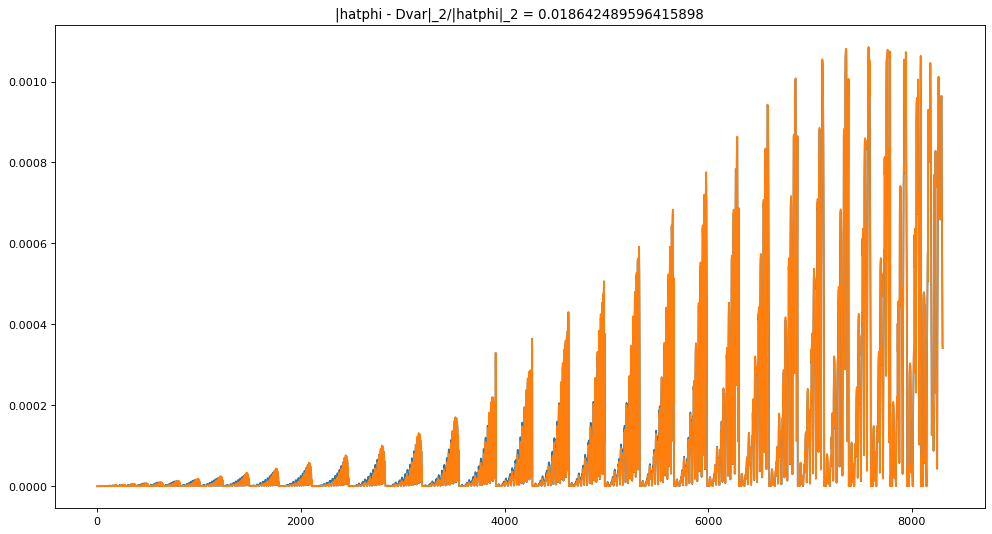

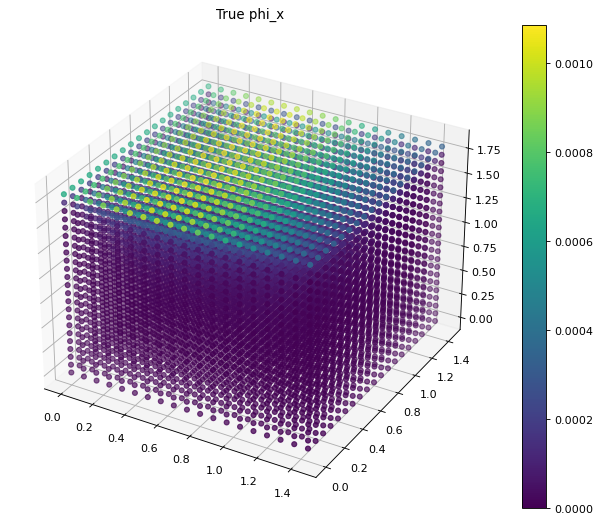

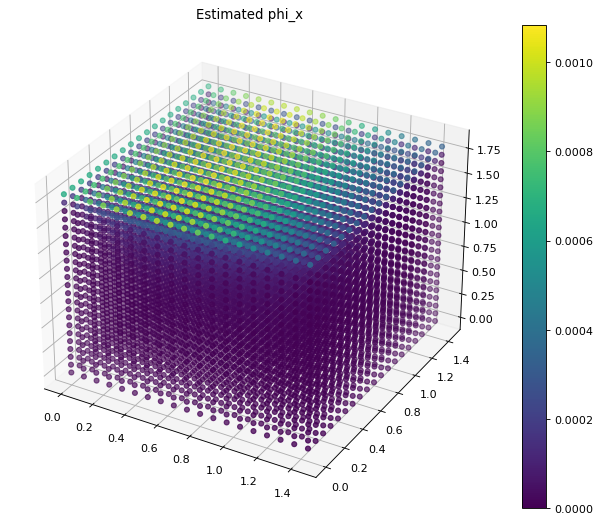

In [47]:
Sf_est = Tr_inner@Svar.value
print('#(Sf_est>Dvar) = ', len(Sf_est[Sf_est > Dvar.value]), 'Min phibar = ',np.min(phibar_scaled.vector()[:])*0.7, 'Min. Dvar = ', np.min(Dvar.value), 'Min Svar = ', np.min(Svar.value))
# Sf_est = Svar.value
# Sf_est[Svar.value<=1e-6]=0
print('Rel. emission eq. error = ', np.linalg.norm(A_bdr@Sf_est - y_tr_scaled)/np.linalg.norm(y_tr_scaled))
# print('Rel. emission eq. error = ', np.linalg.norm(S_emit@PhiEmvar.value - float(Gm)*M@Sf_est)/np.linalg.norm(float(Gm)*M@Sf_est))

print('Rel. excitation eq. error =', np.linalg.norm(S_excite@Dvar.value + M@Sf_est - src_bndr_scaled)/np.linalg.norm( src_bndr_scaled))
# print('Rel. |hatphi - Dvar|/|hatphi| =', np.linalg.norm(Dvar.value - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:]))
# print('NNz =', len(Sf_est) - (Sf_est<=1e-3).sum(), 'Dim = ', len(Sf_est))

# tmp_ratio = Sf_est/Dvar.value
# print('Ratios (min, av, max)', np.min(tmp_ratio), np.abs(np.mean(tmp_ratio)),np.max(tmp_ratio))
# plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(np.abs(tmp_ratio))
# plt.plot(np.mean(tmp_ratio)*np.ones_like(tmp_ratio))

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Dvar.value)
plt.plot(hatphi_scaled.vector()[:])
# plt.colorbar(img)
msg = np.array(("|hatphi - Dvar|_2/|hatphi|_2 = "))
err_str = np.format_float_positional(np.linalg.norm(Dvar.value - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:]))
plt.title(np.char.add(msg,err_str))

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,2)
img = fem.plot(hatphi_scaled)
plt.colorbar(img)
plt.title('True phi_x')

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
sol1 = fem.Function(Q)
sol1.vector()[:] = Dvar.value
img1 = fem.plot(sol1)
plt.colorbar(img1)
plt.title('Estimated phi_x')

print('KL(Sf_est, Dvar) = ', cp.sum(cp.rel_entr(Svar/float(ICG_absoption_coeff), Dvar[is_dof_inner])).value,'\nRel. entropy (log-sum) = ', scipy.special.rel_entr(Sf_est.sum()/float(ICG_absoption_coeff), Dvar.value.sum()))#, np.log(np.abs(np.mean(Sf_est/Dvar.value)))*Sf_est.sum())
print('KL(Sf_true, phi_bar - S_x\M Sf_true) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff), phiSf_scaled.vector()[:]).sum())#,scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),hatphi_scaled.vector()[:]).sum())
print('KL(Sf_true, Dvar) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),Dvar.value).sum())
print('|Sf_true|_1 = ', np.abs(Sf_scaled.vector()[:]).sum(), '\n|Sf_est|_1 = ', np.abs(Sf_est).sum(), '\n|Tr Sf|_1 = ',np.abs(Tr_near@Sf_scaled.vector()[:]).sum(), '\n|Tr Sf_est|_1 = ',np.abs(Tr_near@Sf_est).sum())
# print('Cost(Sf_true) = ', np.abs(np.log(low_bound))/float(ICG_absoption_coeff)*np.abs(Sf_scaled.vector()[:]).sum() + scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(), '\nCost(Sf_est,Dvar) = ', cost.value) 
print(Dvar.value.sum(),Sf_est.sum()/float(ICG_absoption_coeff))

In [85]:
# UNIT TEST:  TV regularization
# Dvar1 = phibar_scaled.vector()[:]
Dvar1 = Dvar.value
y_tr_sign = y_tr_scaled

A_bdr_scaled = A_bdr 
mF = A_bdr_scaled@np.diag(Dvar1*float(ICG_absoption_coeff))
data_misfit_normalization = 1/np.linalg.norm(y_tr_sign,2)**2


Svar1 = cp.Variable(shape=Dvar1.shape[0], nonneg=True)

tikh = 1e0
TVreg = cp.tv(Svar1[TV_cubes_index[0,:]])
for jj in range(1,TV_cubes_index.shape[0]): 
    TVreg = TVreg + cp.tv(Svar1[TV_cubes_index[jj,:]])
    
Cost  = data_misfit_normalization*cp.sum_squares(mF@Svar1 - y_tr_sign) + tikh*TVreg
Constraints = [cp.sum(Svar1)>=100, Svar1<=1]
prob = cp.Problem(cp.Minimize(Cost), Constraints)

solver = cp.OSQP
# solver = cp.ECOS
# solver = cp.MOSEK
if solver == cp.OSQP: 
    prob.solve(solver,verbose = True, eps_abs=5e-9, eps_rel=5e-9, max_iter=50000) 
elif solver == cp.ECOS: 
    prob.solve(solver,verbose = True, max_iters=1000) 
elif solver == cp.MOSEK:
    Cost  = TVreg# + cp.sum(cp.abs(Svar1))
    # Cost  = data_misfit_normalization*cp.sum_squares(mF@Svar1 - y_tr_sign) + TVreg
    Constraints = [#cp.sum(Svar1)<=Dvar1.shape[0]/4, 
                   cp.sum(Svar1)>=100, 
                    Svar1<=1, Svar1>=0, 
        cp.norm(mF@Svar1 - y_tr_sign,2)<=0.00001*np.linalg.norm(y_tr_sign,2)]
    prob = cp.Problem(cp.Minimize(Cost), Constraints)
    prob.solve(solver,verbose = True, mosek_params={mosek.iparam.intpnt_solve_form: mosek.solveform.primal, mosek.dparam.intpnt_co_tol_pfeas: 1e-12, mosek.dparam.intpnt_co_tol_infeas: 1e-12})


# cp.Problem(cp.Minimize(Cost),[cp.sum(Svar1)>=100, Svar1<=1]).solve(verbose=True, solver=cp.MOSEK, mosek_params={mosek.iparam.intpnt_solve_form: mosek.solveform.primal, mosek.dparam.intpnt_co_tol_pfeas: 1e-11, mosek.dparam.intpnt_co_tol_infeas: 1e-11}))
# cp.Problem(cp.Minimize(Cost),[cp.sum(Svar1)>=100, Svar1<=1]).solve(verbose=True, eps_abs=2e-9, eps_rel=2e-9, max_iter=50000)
# cp.Problem(cp.Minimize(cp.tv(Svar1)),[mF@Svar1 == y_tr_sign]).solve(verbose=True, solver=cp.SCS)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jul 04 04:10:27 PM: Your problem has 8303 variables, 2 constraints, and 0 parameters.
(CVXPY) Jul 04 04:10:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 04 04:10:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 04 04:10:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 04 04:10:27 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jul 04 04:10:27 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

Data misfit =  1.3364075490762021e-08 TV= 5.3107735574463733e-08
True misfit =  0.09789683371269016 TV=  0.0
Cost =  6.647181106522575e-08 True cost =  0.09789683371269016
Constraint =  382.1790919288767 True constraint =  616.0


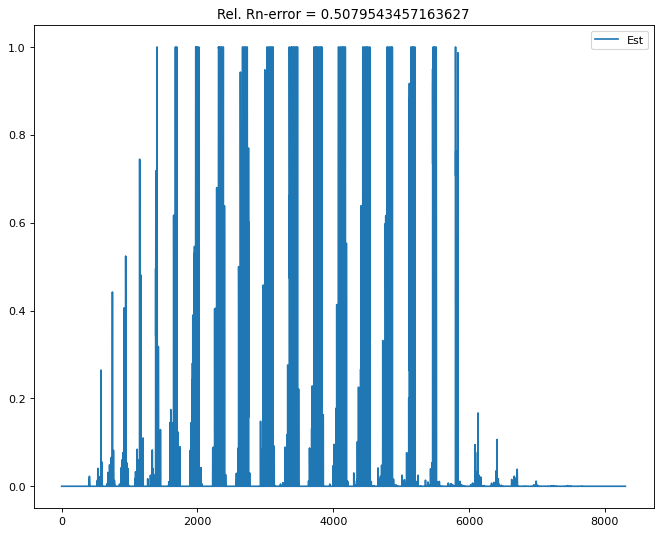

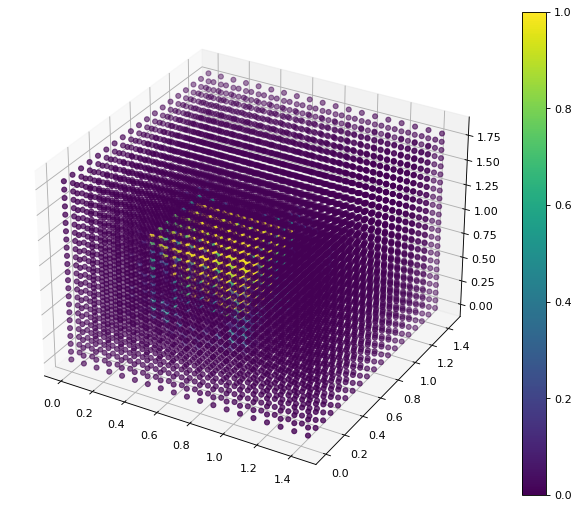

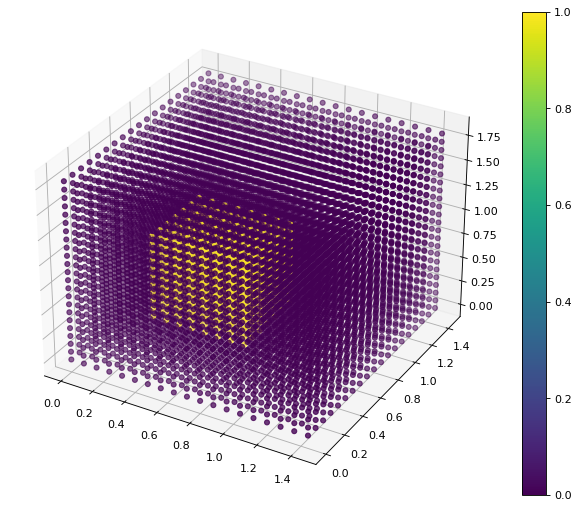

In [86]:
gk    = cp.Parameter(len(mu_axf.vector()[:]))
gk.value = mu_axf.vector()[:]/float(ICG_absoption_coeff)
TVregk = cp.tv(gk[TV_cubes_index[0,:]])
for jj in range(1,TV_cubes_index.shape[0]): 
    TVregk = TVregk + cp.tv(gk[TV_cubes_index[jj,:]])
    
dmsft = data_misfit_normalization*cp.sum_squares(mF@Svar1 - y_tr_scaled).value
dmsft_true = data_misfit_normalization*cp.sum_squares(mF@gk - y_tr_scaled).value 
print('Data misfit = ', dmsft, 'TV=' , TVreg.value)
print('True misfit = ', dmsft_true,'TV= ', TVregk.value)
print('Cost = ', Cost.value, 'True cost = ', dmsft_true + tikh*TVregk.value)
print('Constraint = ', cp.sum(Svar1).value, 'True constraint = ',cp.sum(gk).value)
# print('Cnst.misfit = ', data_misfit_normalization*cp.sum_squares(mF@np.ones_like(Svar1.value)*0.041 - y_tr_scaled).value)

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(Svar1.value,label='Est') 
# plt.plot(gk.value,label='True')
msg = np.array(("Rel. Rn-error = "))
sol1 = fem.Function(Q)
sol1.vector()[:] = Svar1.value
err_str = np.format_float_positional(np.sqrt(fem.assemble((mu_axf/float(ICG_absoption_coeff)-sol1)**2*fem.dx)/fem.assemble((mu_axf/float(ICG_absoption_coeff))**2*fem.dx)))
plt.title(np.char.add(msg,err_str))
plt.legend()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
img1 = fem.plot(sol1)
plt.colorbar(img1)

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
sol1.vector()[:] = gk.value
img1 = fem.plot(sol1)
plt.colorbar(img1)


## SANDBOX

In [ ]:
# UNIT TEST:  Solve with method of multipliers.
A_bdr_scaled = A_bdr 
mF = A_bdr_scaled@np.diag(Dvar.value*float(ICG_absoption_coeff))

y_tr_sign = y_tr_scaled

Svar1 = cp.Variable(shape=nD, nonneg=True)

tikh = 1
# PhiEmvar = cp.Variable(shape=nD, nonneg=True)

Dvar1 = Dvar.value

#                 A_bdr_scaled@dD@Svar1             == y_tr_sign, 
#                 S_emit@PhiEmvar == float(Gm)*M@dD@Svar1,  Tr@PhiEmvar == y_tr_sign]
               #                A_bdr = Tr@np.linalg.solve(S_emit,float(Gm)*M), y_tr_scaled = A_bdr@Sf_scaled.vector()[:]
#                S_emit@PhiEmvar == float(Gm)*M@Tr_inner@Svar,  PhiEmvar>=0, Tr@PhiEmvar == y_tr_sign, ]
#                 S_excite@Dvar.value   +  M@dD@Svar1 == src_bndr_scaled, 
#                 cp.sum(Svar1)<= nD/2 ]#, cp.sum(Svar1) <= float(ICG_absoption_coeff)*1.5*low_bound]

resid = mF@Svar1 - y_tr_sign
lgr_mult = cp.Parameter(len(y_tr_sign))
lgr_mult.value = np.zeros(len(y_tr_sign))
aug_lagr = cp.tv(Svar1) + lgr_mult.T@resid + (tikh/2)*cp.sum_squares(resid)
for t in trange(10):
    cp.Problem(cp.Minimize(aug_lagr), [Svar1<=1, cp.sum(Svar1)>=100]).solve()
    lgr_mult.value += tikh*resid.value
    print("Res value from method of multipliers: {}".format(np.linalg.norm(resid.value)))

In [ ]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
print(np.linalg.norm(mF@mu_axf.vector()[:]/float(ICG_absoption_coeff) - y_tr_scaled),mu_axf.vector()[:].sum(),Svar1.value.sum())
print(np.linalg.norm(mF@Svar1.value - y_tr_scaled)/np.linalg.norm(y_tr_scaled),mu_axf.vector()[:].sum(),Svar1.value.sum()) #Svar1.value - Svar1.value))
plt.plot(Svar1.value)

gk    = cp.Parameter(nD)
gk.value = mu_axf.vector()[:]/float(ICG_absoption_coeff)
print(cp.tv(Svar1).value, cp.tv(gk).value)

In [ ]:
# UNIT TEST: diag trick + L1 minimization 

A_bdr_scaled = A_bdr 
mF = A_bdr_scaled@dD
dD = np.diag(Dvar.value*float(ICG_absoption_coeff))
y_tr_sign = y_tr_scaled#np.sign(y_tr_scaled)

# Svar1 = cp.Variable(shape=nS, nonneg=True)
Svar1 = cp.Variable(shape=nD, nonneg=True)
gk    = cp.Parameter(len(y_tr_sign))  
gk.value = 0*y_tr_sign
tikh = 40 
# PhiEmvar = cp.Variable(shape=nD, nonneg=True)

Dvar1 = Dvar.value


constraints1 = [Svar1<=1]
#                 A_bdr_scaled@dD@Svar1             == y_tr_sign, 
#                 S_emit@PhiEmvar == float(Gm)*M@dD@Svar1,  Tr@PhiEmvar == y_tr_sign]
               #                A_bdr = Tr@np.linalg.solve(S_emit,float(Gm)*M), y_tr_scaled = A_bdr@Sf_scaled.vector()[:]
#                S_emit@PhiEmvar == float(Gm)*M@Tr_inner@Svar,  PhiEmvar>=0, Tr@PhiEmvar == y_tr_sign, ]
#                 S_excite@Dvar.value   +  M@dD@Svar1 == src_bndr_scaled, 
#                 cp.sum(Svar1)<= nD/2 ]#, cp.sum(Svar1) <= float(ICG_absoption_coeff)*1.5*low_bound]

obj1  = cp.Minimize(cp.sum(cp.abs(Svar1)) + tikh/2*cp.sum_squares(mF@Svar1-gk)) 
prob1 = cp.Problem(obj1, constraints1)
prob1.solve(verbose=True)
gk.value = y_tr_sign - mF@Svar1.value 

for jj in trange(250): 
    prob1.solve(warm_start=True,verbose=True)
    gk_prev = gk.value
    gk.value = gk_prev + y_tr_sign - mF@Svar1.value
    print(np.linalg.norm(mF@Svar1.value - y_tr_sign))
#     print('nnz =', (np.absolute(Svar1.value) > 1e-10).sum())
    



In [ ]:
print(cp.installed_solvers())

In [ ]:
# UNIT TEST: Mixed-integer quadratic program

Svar1 = cp.Variable(shape=nD, integer=True)
Dvar1 = Dvar.value


constraints1 = [0<=Svar1, Svar1<=1] 

obj1  = cp.Minimize(cp.sum_squares(A_bdr_scaled@dD@Svar1 - y_tr_sign))
prob1 = cp.Problem(obj1, constraints1)
# prob.solve(solver=cp.SCS,verbose = True)
# prob1.solve(solver=cp.ECOS, verbose = True)#, max_iters = 2000, feastol_inacc = 1e-6)
prob1.solve(verbose = True)

In [ ]:
Sf_est = dD@Svar1.value
print('#(Sf_est>Dvar) = ', len(Sf_est[Sf_est > Dvar.value]), 'Min. Dvar = ', np.min(Dvar.value), 'Min Svar = ', np.min(Svar1.value))
# Sf_est = Svar.value
# Sf_est[Svar.value<=1e-6]=0
print('Rel. emission eq. error = ', np.linalg.norm(A_bdr@Sf_est - y_tr_scaled)/np.linalg.norm(y_tr_scaled))
# print('Rel. excitation eq. error =', np.linalg.norm(S_excite@Dvar.value + M@Sf_est - src_bndr_scaled)/np.linalg.norm( src_bndr_scaled))
# print('Rel. |hatphi - Dvar|/|hatphi| =', np.linalg.norm(Dvar.value - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:]))
# print('NNz =', len(Sf_est) - (Sf_est<=1e-3).sum(), 'Dim = ', len(Sf_est))

# tmp_ratio = Sf_est/Dvar.value
# print('Ratios (min, av, max)', np.min(tmp_ratio), np.abs(np.mean(tmp_ratio)),np.max(tmp_ratio))
# plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(np.abs(tmp_ratio))
# plt.plot(np.mean(tmp_ratio)*np.ones_like(tmp_ratio))

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Svar1.value)
# plt.plot(mu_axf.vector()[:]/float(ICG_absoption_coeff))
# plt.colorbar(img)
msg = np.array(("|Sf_est - Sf_true|_2/|Sf_true|_2 = "))
err_str = np.format_float_positional(np.linalg.norm(Sf_est - Sf_scaled.vector()[:])/np.linalg.norm(Sf_scaled.vector()[:]))
plt.title(np.char.add(msg,err_str))

print('KL(Sf_est, Dvar) = ', scipy.special.rel_entr(Sf_est/float(ICG_absoption_coeff), Dvar.value).sum(),'\nRel. entropy (log-sum) = ', scipy.special.rel_entr(Sf_est.sum()/float(ICG_absoption_coeff), Dvar.value.sum()))#, np.log(np.abs(np.mean(Sf_est/Dvar.value)))*Sf_est.sum())
print('KL(Sf_true, phi_bar - S_x\M Sf_true) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(),scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),hatphi_scaled.vector()[:]).sum())
print('KL(Sf_true, Dvar) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),Dvar.value).sum())
print('|Sf_tru|_1 = ', np.abs(Sf_scaled.vector()[:]).sum(), '\n|Sf_est|_1 = ', np.abs(Sf_est).sum(), '\n|Tr Sf|_1 = ',np.abs(Tr_near@Sf_scaled.vector()[:]).sum(), '\n|Tr Sf_est|_1 = ',np.abs(Tr_near@Sf_est).sum())


In [ ]:
# UNIT TEST: relative entropy minimization 
reg_par = 0.9
# A_bdr_scaled = np.diag(1/np.abs(y_tr_scaled))@A_bdr#/np.transpose(np.matlib.repmat(y_tr_scaled,A_bdr.shape[1],1))
A_bdr_scaled = A_bdr 
y_tr_sign = y_tr_scaled#np.sign(y_tr_scaled)

# Svar1 = cp.Variable(shape=nS, nonneg=True)
Svar1 = cp.Variable(shape=nD, nonneg=True)

Phivar = cp.Variable(shape=nD)
# Dvar1 = Dvar.value[is_dof_inner] 
Dvar1 = Dvar.value


constraints1 = [#Svar1>=1e-7, Svar1<=Dvar1, 
#                 S_emit@Phivar == float(Gm)*M@Tr_inner@Svar1,  Phivar>=0, 
#                A_bdr_scaled@Tr_inner@Svar1 == y_tr_sign, 
               A_bdr_scaled@Svar1 == y_tr_sign, 
               cp.sum(Svar1)>=low_bound*float(ICG_absoption_coeff)]#, cp.sum(Svar1) <= float(ICG_absoption_coeff)*1.5*low_bound]

# obj1  = cp.Minimize(cp.sum(cp.rel_entr(Svar1/float(ICG_absoption_coeff), Dvar1)))# +  5/2*np.abs(np.log(low_bound))/float(ICG_absoption_coeff)*cp.sum(Svar1))# + 1/2*cp.sum(cp.square(A_bdr@Svar - y_tr)))
obj1  = cp.Minimize((1-reg_par)*cp.sum(cp.rel_entr(Svar1/float(ICG_absoption_coeff), Dvar1)) + reg_par*cp.sum(cp.abs(Svar1)))# + cp.sum(cp.square(Tr@Phivar - y_tr_sign)))#1e1/2*cp.sum(cp.square(A_bdr_scaled@Tr_inner@Svar1 - y_tr_sign)))
prob1 = cp.Problem(obj1, constraints1)
# lmbd.value = 1
# prob.solve(solver=cp.SCS,verbose = True)
# prob1.solve(solver=cp.ECOS, verbose = True)#, max_iters = 2000, feastol_inacc = 1e-6)
prob1.solve(verbose = True, max_iters = 200)

In [ ]:
Sf_est = Svar1.value
print('#(Sf_est>Dvar) = ', len(Sf_est[Sf_est > Dvar.value]), 'Min. Dvar = ', np.min(Dvar.value), 'Min Svar = ', np.min(Svar1.value))
# Sf_est = Svar.value
# Sf_est[Svar.value<=1e-6]=0
print('Rel. emission eq. error = ', np.linalg.norm(A_bdr@Sf_est - y_tr_scaled)/np.linalg.norm(y_tr_scaled))
# print('Rel. excitation eq. error =', np.linalg.norm(S_excite@Dvar.value + M@Sf_est - src_bndr_scaled)/np.linalg.norm( src_bndr_scaled))
# print('Rel. |hatphi - Dvar|/|hatphi| =', np.linalg.norm(Dvar.value - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:]))
# print('NNz =', len(Sf_est) - (Sf_est<=1e-3).sum(), 'Dim = ', len(Sf_est))

# tmp_ratio = Sf_est/Dvar.value
# print('Ratios (min, av, max)', np.min(tmp_ratio), np.abs(np.mean(tmp_ratio)),np.max(tmp_ratio))
# plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(np.abs(tmp_ratio))
# plt.plot(np.mean(tmp_ratio)*np.ones_like(tmp_ratio))

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Sf_est)
plt.plot(Sf_scaled.vector()[:])
# plt.colorbar(img)
msg = np.array(("|Sf_est - Sf_true|_2/|Sf_true|_2 = "))
err_str = np.format_float_positional(np.linalg.norm(Sf_est - Sf_scaled.vector()[:])/np.linalg.norm(Sf_scaled.vector()[:]))
plt.title(np.char.add(msg,err_str))

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,2)
sol1 = fem.Function(Q)
sol1.vector()[:] = Sf_est
img = fem.plot(sol1)
plt.colorbar(img)
plt.title('True phi_x')

print('KL(Sf_est, Dvar) = ', scipy.special.rel_entr(Sf_est/float(ICG_absoption_coeff), Dvar.value).sum(),'\nRel. entropy (log-sum) = ', scipy.special.rel_entr(Sf_est.sum()/float(ICG_absoption_coeff), Dvar.value.sum()))#, np.log(np.abs(np.mean(Sf_est/Dvar.value)))*Sf_est.sum())
print('KL(Sf_true, phi_bar - S_x\M Sf_true) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(),scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),hatphi_scaled.vector()[:]).sum())
print('KL(Sf_true, Dvar) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),Dvar.value).sum())
print('|Sf_tru|_1 = ', np.abs(Sf_scaled.vector()[:]).sum(), '\n|Sf_est|_1 = ', np.abs(Sf_est).sum(), '\n|Tr Sf|_1 = ',np.abs(Tr_near@Sf_scaled.vector()[:]).sum(), '\n|Tr Sf_est|_1 = ',np.abs(Tr_near@Sf_est).sum())
print('Cost(Sf_tru) = ', reg_par*np.abs(Sf_scaled.vector()[:]).sum() + (1-reg_par)*scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(), '\nCost(Sf_est) = ', reg_par*np.abs(Sf_est).sum() + (1-reg_par)*scipy.special.rel_entr(Sf_est/float(ICG_absoption_coeff), Dvar.value).sum())
print(Dvar.value.sum(),Sf_est.sum()/float(ICG_absoption_coeff))

In [ ]:
# UNIT TEST: relative entropy minimization 
Svar_pos = cp.Variable(shape=nD,nonneg=True)
Dvar1 = Dvar.value 

A_bdr1  = A_bdr#@Tr_inner
P_nullA = np.eye(A_bdr1.shape[1]) - np.linalg.pinv(A_bdr1)@A_bdr1

Sf_min2norm = np.linalg.pinv(A_bdr1)@y_tr_scaled 
print(np.linalg.norm(A_bdr1@Sf_min2norm - y_tr_scaled)/np.linalg.norm(y_tr_scaled), np.linalg.norm(P_nullA@(Sf_min2norm-Sf_scaled.vector()[:]) - (Sf_min2norm-Sf_scaled.vector()[:])))

In [ ]:
constraints_pos = [Svar_pos>=0, Svar_pos<=Dvar1] 
obj_pos         = cp.Minimize(cp.sum(cp.square(A_bdr1@Svar_pos - y_tr_scaled)))
prob_pos        = cp.Problem(obj_pos, constraints_pos) 
prob_pos.solve(verbose = True,eps_rel=1e-8)

In [ ]:
Svar1 = cp.Variable(shape=nD,nonneg=True)
Phivar = cp.Variable(shape=nD)
Dvar1 = Dvar.value

constraints1 = [Svar1<=Dvar1, cp.sum(Svar1) == cp.sum(Sf_scaled.vector()[:]), #Svar1 == Sf_min2norm + P_nullA@Phivar, 
               Svar1@Dvar1 == Sf_scaled.vector()[:]@Sf_scaled.vector()[:]]# low_bound*float(ICG_absoption_coeff)]#, cp.sum(Svar1) <= float(ICG_absoption_coeff)*1.5*low_bound]

# obj1  = cp.Minimize(cp.sum(cp.rel_entr(Svar1/float(ICG_absoption_coeff), Dvar1)))# +  5/2*np.abs(np.log(low_bound))/float(ICG_absoption_coeff)*cp.sum(Svar1))# + 1/2*cp.sum(cp.square(A_bdr@Svar - y_tr)))
obj1  = cp.Minimize(cp.sum(cp.rel_entr(Svar1/float(ICG_absoption_coeff), Dvar1)) + 5*cp.sum(cp.abs(Svar1)))# + cp.sum(cp.square(Tr@Phivar - y_tr_sign)))#1e1/2*cp.sum(cp.square(A_bdr_scaled@Tr_inner@Svar1 - y_tr_sign)))
prob1 = cp.Problem(obj1, constraints1)
# lmbd.value = 1
# prob.solve(solver=cp.SCS,verbose = True)
# prob1.solve(solver=cp.ECOS, verbose = True)#, max_iters = 2000, feastol_inacc = 1e-6)
prob1.solve(verbose = True, max_iters = 2000)

In [ ]:
np.abs(Sf_est@Dvar1 - Sf_scaled.vector()[:]@Sf_scaled.vector()[:])/np.abs(Sf_scaled.vector()[:]@Sf_scaled.vector()[:])
np.sum(Sf_est)

In [ ]:
Sf_est = Svar1.value
print('#(Sf_est>Dvar) = ', len(Sf_est[Sf_est > Dvar.value]), 'Min. Dvar = ', np.min(Dvar.value), 'Min Svar = ', np.min(Svar1.value))
# Sf_est = Svar.value
# Sf_est[Svar.value<=1e-6]=0
print('Rel. emission eq. error = ', np.linalg.norm(A_bdr@Sf_est - y_tr_scaled)/np.linalg.norm(y_tr_scaled))
# print('Rel. excitation eq. error =', np.linalg.norm(S_excite@Dvar.value + M@Sf_est - src_bndr_scaled)/np.linalg.norm( src_bndr_scaled))
# print('Rel. |hatphi - Dvar|/|hatphi| =', np.linalg.norm(Dvar.value - hatphi_scaled.vector()[:])/np.linalg.norm(hatphi_scaled.vector()[:]))
# print('NNz =', len(Sf_est) - (Sf_est<=1e-3).sum(), 'Dim = ', len(Sf_est))

tmp_ratio = Sf_est/Dvar.value
print('Ratios (min, av, max)', np.min(tmp_ratio), np.abs(np.mean(tmp_ratio)),np.max(tmp_ratio))
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.abs(tmp_ratio))
plt.plot(np.mean(tmp_ratio)*np.ones_like(tmp_ratio))

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(Sf_est)
plt.plot(Sf_est)
plt.plot(Dvar1*np.sum(Sf_scaled.vector()[:]))
# plt.colorbar(img)
msg = np.array(("|Sf_est - Sf_true|_2/|Sf_true|_2 = "))
err_str = np.format_float_positional(np.linalg.norm(Sf_est - Sf_scaled.vector()[:])/np.linalg.norm(Sf_scaled.vector()[:]))
plt.title(np.char.add(msg,err_str))

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,2)
sol1 = fem.Function(Q)
sol1.vector()[:] = Sf_est
img = fem.plot(sol1)
plt.colorbar(img)
plt.title('True phi_x')

print('KL(Sf_est, Dvar) = ', scipy.special.rel_entr(Sf_est/float(ICG_absoption_coeff), Dvar.value).sum(),'\nRel. entropy (log-sum) = ', scipy.special.rel_entr(Sf_est.sum()/float(ICG_absoption_coeff), Dvar.value.sum()))#, np.log(np.abs(np.mean(Sf_est/Dvar.value)))*Sf_est.sum())
print('KL(Sf_true, phi_bar - S_x\M Sf_true) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(),scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),hatphi_scaled.vector()[:]).sum())
print('KL(Sf_true, Dvar) = ', scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),Dvar.value).sum())
print('|Sf_tru|_1 = ', np.abs(Sf_scaled.vector()[:]).sum(), '\n|Sf_est|_1 = ', np.abs(Sf_est).sum(), '\n|Tr Sf|_1 = ',np.abs(Tr_near@Sf_scaled.vector()[:]).sum(), '\n|Tr Sf_est|_1 = ',np.abs(Tr_near@Sf_est).sum())
print('Cost(Sf_tru) = ', np.abs(Sf_scaled.vector()[:]).sum() + scipy.special.rel_entr(Sf_scaled.vector()[:]/float(ICG_absoption_coeff),phibar_scaled.vector()[:] - A_excite@Sf_scaled.vector()[:]).sum(), '\nCost(Sf_est) = ', np.abs(Sf_est).sum() + scipy.special.rel_entr(Sf_est/float(ICG_absoption_coeff), Dvar.value).sum())
print(Dvar.value.sum(),Sf_est.sum()/float(ICG_absoption_coeff))

In [ ]:
plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(Sf_est)
plt.plot(Sf_min2norm)
plt.plot(Dvar1/2)



In [ ]:
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
tmp = fem.plot(Sf_scaled)
plt.colorbar(tmp)

In [ ]:
plt.plot(Sf_scaled.vector()[:])
print(np.mean(Svar.value[0:900]), np.mean(Svar.value[1000:]))

In [ ]:
0.038*np.log(0.038)

In [ ]:
# UNIT test: log-inequlity
n=6
mA = np.random.rand(2,n)
mB = np.random.rand(n,n)
true_x = np.array([1,1,0,0,0,1])
vecB1 = mB@true_x
vecB2 = mA@true_x 
scipy.special.rel_entr(true_x,vecB1 - true_x).sum()

In [ ]:
x = cp.Variable(shape=n)
tmp = cp.Variable(shape=n)

constraints = [x>=0, tmp>=0, tmp<=vecB1, tmp == vecB1 - x, mA@x == vecB2]
# cp.sum(cp.rel_entr(x,tmp)) + 5*
obj  = cp.Minimize(cp.sum(cp.rel_entr(x,tmp)))

prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.SCS, max_iters = 200000, eps = 1e-10)
# prob.solve(verbose = True)

In [ ]:
# Print result.
print("\nThe cvxpy min value = ", prob.value, "\nThe log-ineq min value = ", scipy.special.rel_entr(x.value.sum(),tmp.value.sum()))
print('The cvxpy scaling =', np.abs(np.mean(x.value/tmp.value)), x.value/tmp.value, '\nOptimal log-ineq. scaling = ', np.exp(-1))
print('x   = ', x.value, '\ntmp = ', tmp.value, '\n 1st eq = ', np.linalg.norm(x.value + tmp.value-vecB1)/np.linalg.norm(vecB1), '\n 2nd eq = ', np.linalg.norm(mA@x.value - vecB2)/np.linalg.norm(vecB2))

# print('Log-sum inequality = ', scipy.special.rel_entr(x.value.sum(),tmp.value.sum()), np.log(np.abs(np.mean(x.value/tmp.value)))*x.value.sum())

In [ ]:
# print(np.linalg.norm(tmp.value - (vecB-x.value))/np.linalg.norm(tmp.value))
print(x.value)

In [ ]:
print(np.linalg.norm(rhs_vec-float(Gm)*mu_axf.vector()[:],1)/np.linalg.norm(-float(Gm)*mu_axf.vector()[:],1), np.linalg.norm(-float(Gm)*mu_axf.vector()[:],1))